In [2]:
import scipy.stats as stats
import itertools
import scipy.optimize

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle, Ellipse
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count() - 2

import importlib
import data_loader as dl
from networks.mnist import *

In [3]:
from torch import relu
import torch
from torch.nn.parameter import Parameter
import torch.distributions.beta
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import datasets, transforms
nn = torch.nn

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
os.rename()

# Generate data

In [4]:
importlib.reload(netx)
importlib.reload(dl)

M = 1024
mode = 'context-no-info'
#['baseline', 'correlated', 'missing', 'context-no-info', 'img-no-info', 'multiple']

Tx = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_loader = data.DataLoader(dl.Custom_Mnist_Dataset('data', mode=mode, train=True, refresh=False,
                       transform=Tx), batch_size=M, num_workers=4, shuffle=True, pin_memory=True)

test_loader = data.DataLoader(dl.Custom_Mnist_Dataset('data', mode=mode, train=False, refresh=False,
                       transform=Tx), batch_size=M, num_workers=4, shuffle=True, pin_memory=True)

h = train_loader.dataset.huy[:,0].numpy()
u = train_loader.dataset.huy[:,1].numpy()
if mode == 'context-no-info':
    y_noiseless_train = np.round(h*2/3)
elif mode == 'img-no-info':
    y_noiseless_train = np.round(u*18/3)
elif mode == 'missing':
    u_scale = np.round(u*9).reshape((-1,1))
    h_rep = h.reshape((-1,1))
    u_hat = np.tile(np.arange(10), (u.shape[0],1))
    u_hat = np.argmax(1e4*(u_scale == u_hat) + stats.binom.pmf(u_hat, n=h_rep, p=.7) * (h_rep-u_hat+1), 1)
    y_noiseless_train = np.round((h + u_hat)/3)
elif mode == 'multiple':
    #huvwy
    v = train_loader.dataset.huy[:,2].numpy()
    w = train_loader.dataset.huy[:,3].numpy()
    y_noiseless_train = np.round((h + u*9 - v*6 + w*6)/3)
else:
    y_noiseless_train = np.round((h + u*9)/3)
    
h = test_loader.dataset.huy[:,0].numpy()
u = test_loader.dataset.huy[:,1].numpy()
if mode == 'context-no-info':
    y_noiseless_test = np.round(h*2/3)
elif mode == 'img-no-info':
    y_noiseless_test = np.round(u*18/3)
elif mode == 'missing':
    u_scale = np.round(u*9).reshape((-1,1))
    h_rep = h.reshape((-1,1))
    u_hat = np.tile(np.arange(10), (u.shape[0],1))
    u_hat = np.argmax(1e4*(u_scale == u_hat) + stats.binom.pmf(u_hat, n=h_rep, p=.7) * (h_rep-u_hat+1), 1)
    y_noiseless_test = np.round((h + u_hat)/3)
elif mode == 'multiple':
    #huvwy
    v = test_loader.dataset.huy[:,2].numpy()
    w = test_loader.dataset.huy[:,3].numpy()
    y_noiseless_test = np.round((h + u*9 - v*6 + w*6)/3)
else:
    y_noiseless_test = np.round((h + u*9)/3)

N = y_noiseless_train.shape[0]

In [21]:
def print_stats(test=True):
    if test:
        L = test_loader
        Y_noiseless = y_noiseless_test
    else:
        L = train_loader
        Y_noiseless = y_noiseless_train
        
    y = L.dataset.huy[:,-1].numpy()
    N = y.size
    true_dev = np.abs(np.round(y*6) - Y_noiseless).sum()/N
    true_acc = (np.round(y*6) == Y_noiseless).sum()/N

    avg_dev = 0
    avg_acc = 0
    for I, huy in L:
        u = huy[:,1:-1].float().cuda()
        y = huy[:,-1].numpy()
        p_Y_UX = model.classify(I.float().cuda(), u)
        Y_pred = p_Y_UX.max(1)[1].cpu().numpy() #p_Y_UX.detach().cpu().numpy()
        Y_pred = np.round(np.clip(Y_pred, 0,6))
        avg_dev += np.abs(np.round(y*6) - Y_pred).sum()
        avg_acc += (np.round(y*6) == Y_pred).sum()
    avg_dev /= N
    avg_acc /= N

    print("Mean deviation: %.3f/%.3f" % (avg_dev, true_dev))
    print("Accuracy: %.1f%%/%.1f%%" % (avg_acc*100, true_acc*100))
    print(np.unique(np.round(y*6), return_counts=True))
    print(np.unique(Y_pred, return_counts=True))

## MNIST CNN

In [509]:
importlib.reload(netx)
importlib.reload(dl)
model = netx.MnistCNN().cuda()
par_model = torch.nn.DataParallel(model, device_ids=[0,1,2,3])

optimizer = torch.optim.Adam(model.parameters(), lr=.005)
loss_fn = nn.modules.loss.CrossEntropyLoss()

In [ ]:
epochs = 15
for epoch in range(epochs):
    for batch_idx, (imgs, huy) in enumerate(train_loader):
        imgs, huy = imgs.cuda().float(), huy.cuda()
        loss = loss_fn(par_model(imgs), huy[:,0].long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * M, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [219]:
L = test_loader
x = L.dataset.imgs.float().cuda()
H = L.dataset.huy[:,0].numpy()
H_pred = model(x).max(1)[1].cpu().numpy()
print((H == H_pred).sum()/H.size)

0.9512


## Naive CNN

In [27]:
importlib.reload(netx)
importlib.reload(dl)

model = netx.NaiveCNN('x-ent', num_vars=1).cuda()
par_model = torch.nn.DataParallel(model, device_ids=[0,1,2,3])

loss_fn = nn.modules.loss.CrossEntropyLoss()

In [ ]:
epochs = 50
optimizer = torch.optim.SGD(model.parameters(), lr=.01, weight_decay=.0001, momentum=0.5, nesterov=True)
patience = 3
loss_hist = [np.inf]*patience

for epoch in range(epochs):
    cum_loss = 0
    for batch_idx, (imgs, huy) in enumerate(train_loader):
        imgs, huy = imgs.cuda().float(), huy.cuda()
        loss = loss_fn(par_model(imgs, huy[:,1:-1].float()), torch.round(huy[:,-1]*6).long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        cum_loss += loss.item()
        
    print('Epoch: {} \tLoss: {:.2f}'.format(epoch, cum_loss))
            
    loss_hist.append(cum_loss)
    if np.min(cum_loss - np.array(loss_hist[-1-patience:])) >= 0:
        break

In [29]:
print_stats(test=False)
print_stats(test=True)

Mean deviation: 0.044/0.000
Accuracy: 98.3%/100.0%
(array([0., 1., 2., 3., 4., 5., 6.]), array([ 73, 128,  47, 113,  48, 135,  64]))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 73, 128,  49, 112,  48, 136,  62]))
Mean deviation: 0.048/0.000
Accuracy: 98.1%/100.0%
(array([0., 1., 2., 3., 4., 5., 6.]), array([ 83, 159,  77, 154,  82, 147,  82]))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 84, 158,  79, 153,  80, 145,  85]))


In [30]:
xent_state_dict = model.state_dict()

In [31]:
torch.save(xent_state_dict, "xent.pth")

In [32]:
def fill_state(M, pretrained_state):
    state_dict = M.state_dict()
    missing_keys = set(state_dict.keys()).difference(set(pretrained_state.keys()))
    for key in missing_keys:
        pretrained_state[key] = state_dict[key]
    return pretrained_state

In [43]:
importlib.reload(netx)
model = netx.TestModel(K=128).cuda()
pretrained_state = torch.load("xent.pth")
model.load_state_dict(fill_state(model, pretrained_state))
par_model = torch.nn.DataParallel(model, device_ids=range(8))

## MixModelCNN

In [23]:
importlib.reload(netx)
importlib.reload(dl)
K = 256
model = netx.MixModelCNN(K, hidden_var=False).cuda()
par_model = torch.nn.DataParallel(model, device_ids=range(8))

In [ ]:
epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=.01, weight_decay=.0001, momentum=0.5, nesterov=True)
#optimizer = torch.optim.Adam(model.parameters(), lr=.005)
patience = 3
loss_hist = [np.inf]*patience

for epoch in range(epochs):
    cum_loss = 0
    for batch_idx, (imgs, huy) in enumerate(train_loader):
        huy = huy.cuda()
        loss = model.pretrain(huy[:,1:])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        cum_loss += loss.item()
        
    print('Epoch: {} \tLoss: {:.2f}'.format(epoch, cum_loss))
    
    loss_hist.append(cum_loss)
    if np.min(cum_loss - np.array(loss_hist[-1-patience:])) >= 0:
        break

In [ ]:
epochs = 50
optimizer = torch.optim.SGD(model.parameters(), lr=.001, weight_decay=.001, momentum=0.5, nesterov=True)
patience = 3
loss_hist = [np.inf]*patience

for epoch in range(epochs):
    cum_loss = 0
    for batch_idx, (imgs, huy) in enumerate(train_loader):
        imgs, huy = imgs.cuda(), huy.cuda()
        loss = par_model(imgs, huy[:,1:]).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        cum_loss += loss.item()
        
    print('Epoch: {} \tLoss: {:.2f}'.format(epoch, cum_loss))
            
    loss_hist.append(cum_loss)
    if np.min(cum_loss - np.array(loss_hist[-1-patience:])) >= 0:
        break

In [ ]:
print_stats(test=False)
print_stats(test=True)

del optimizer
torch.cuda.empty_cache()

In [480]:
a_u, b_u, a_y, b_y = model.get_ab(cuda=False)

In [481]:
b_u.max()

64.034996

## Plotting

In [450]:
importlib.reload(netx)
importlib.reload(dl)

<module 'data_loader' from '/data/vision/polina/users/clintonw/code/vision_final/data_loader.py'>

In [413]:
def plot_beta_pdf(a,b):
    X = np.linspace(0.01,.99,1000)
    Y = [stats.beta.pdf(X, a=a.detach().cpu().numpy()[0,i], b=b.detach().cpu().numpy()[0,i]) for i in range(K)]
    [plt.plot(X,Y[i]) for i in range(K)];

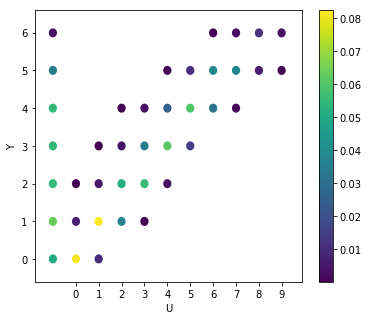

In [755]:
uy = train_loader.dataset.huy[:,1:].numpy()
#uy[uy < 0] = -1/9
coords, freq = np.unique(uy, axis=0, return_counts=True)
alpha_cm = LinearSegmentedColormap.from_list('transparent_cm', [(0,0,0,0), (0,0,0,1)])

fig, ax = plt.subplots(figsize=(6,5))

p_z = freq/freq.sum()
patches = []
for x1, y1, r in zip(coords[:,0], coords[:,1], p_z**.5):
    circle = Circle((x1, y1), .02)#r/5) #.02
    patches.append(circle)

p = PatchCollection(patches)
#p.set_color((.4,.4,.4))
p.set_array(np.array(p_z))
#p.set_cmap(alpha_cm)
#p.set_clim(0, .01)
ax.add_collection(p)
fig.colorbar(p, ax=ax)
plt.xticks(np.linspace(0,1,10), range(10))
#plt.xticks(np.linspace(-1/9,1,11), range(-1,10))
plt.yticks(np.linspace(0,1,7), range(7))
plt.xlim(-.1,1.1)
#plt.xlim(-.2,1.1)
plt.ylim(-.1,1.1)
plt.xlabel('U');
plt.ylabel('Y');

In [776]:
def plot_beta_2d_pdf(model):
    a_u, b_u, a_y, b_y = model.get_ab(cuda=False)
    mu_X = stats.beta.mean(a_u,b_u)
    mu_Y = stats.beta.mean(a_y,b_y)
    sig_X = stats.beta.var(a_u,b_u)**.5
    sig_Y = stats.beta.var(a_y,b_y)**.5
    
    fig, ax = plt.subplots(figsize=(6,5))

    patches = []
    for x1, y1, rx, ry in zip(mu_X, mu_Y, sig_X, sig_Y):
        ell = Ellipse((x1, y1), rx, ry)
        patches.append(ell)

    p = PatchCollection(patches, alpha=.05)
    
    """if p_z is not None:
        p_z = cuda_to_np(p_z)
        p.set_array(np.array(p_z/sig_X/sig_Y))
        p.set_cmap(alpha_cm)
        #p.set_clim(0, round(np.max(p_z/sig_X/sig_Y)))"""
        
    ax.add_collection(p)
    #if p_z is not None:
    #    fig.colorbar(p, ax=ax)

    plt.xlim(-.1,1.1)
    plt.ylim(-.1,1.1)

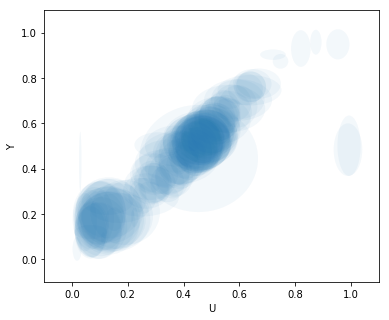

In [777]:
plot_beta_2d_pdf(model)
plt.xlabel('U');
plt.ylabel('Y');

In [778]:
def plot_beta_2d_pdf(model):
    R = 128
    a_u, b_u, a_y, b_y = model.get_ab(cuda=False)
    X = np.linspace(0.01,.99,R)
    Y = np.linspace(0.01,.99,R)
    
    fill_Z = lambda i,j: sum([stats.beta.pdf(X[i], a_u[k], b_u[k]) * stats.beta.pdf(Y[j], a_y[k], b_y[k]) for k in range(K)])
    Z = np.reshape(Parallel(n_jobs=num_cores)(delayed(fill_Z)(i,j) for (i,j) in itertools.product(range(R),range(R))), (R,R)).transpose((1,0))
    
    return Z

In [779]:
Z = plot_beta_2d_pdf(model)

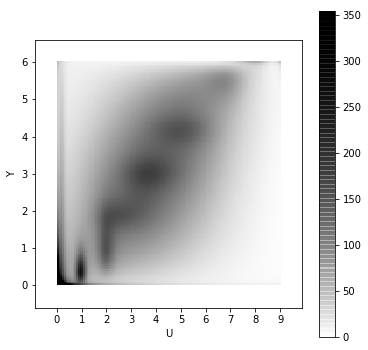

In [780]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(Z, cmap=alpha_cm, vmin=0, vmax=round(np.percentile(Z,99.8)), aspect=1.5, extent=[0,9,6,0])
fig.colorbar(ax.get_children()[-2], ax=ax)
plt.xticks(range(10))
plt.xlim(-.9,9.9)
plt.ylim(-.6,6.6)

plt.xlabel('U');
plt.ylabel('Y');